In [16]:
# 1) 라이브러리
import os, math, random, re
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, utils
import matplotlib.pyplot as plt

import seaborn as sns

SEED = 42
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

# 2) 데이터 경로
DATA_PATH = "/content/drive/MyDrive/Colab Notebooks/WISDM_ar_v1.1_raw.txt"

In [17]:
# 3) 견고한 파서 (정규식 기반)
def load_wisdm_regex(path):
    # user(int), activity(str), timestamp(int), x(float), y(float), z(float)
    pat = re.compile(
        r'^\s*(\d+)\s*,\s*([A-Za-z_]+)\s*,\s*(\d+)\s*,\s*'  # user, activity, ts
        r'([+-]?(?:\d+(?:\.\d+)?|\.\d+))\s*,\s*'            # x
        r'([+-]?(?:\d+(?:\.\d+)?|\.\d+))\s*,\s*'            # y
        r'([+-]?(?:\d+(?:\.\d+)?|\.\d+))\s*;?\s*$'          # z
    )
    rows = []
    skipped = 0
    with open(path, "r", encoding="utf-8", errors="ignore") as f:
        for line in f:
            m = pat.match(line)
            if not m:
                skipped += 1
                continue
            user = int(m.group(1))
            activity = m.group(2)
            ts = int(m.group(3))
            x = float(m.group(4))
            y = float(m.group(5))
            z = float(m.group(6))
            rows.append((user, activity, ts, x, y, z))
    df = pd.DataFrame(rows, columns=["user","activity","timestamp","x","y","z"])
    print(f"[INFO] Parsed {len(df):,} rows. Skipped {skipped:,} malformed lines.")
    # 타임스탬프 정렬 + 타입 고정
    df = df.sort_values("timestamp").reset_index(drop=True)
    df["user"] = df["user"].astype(int)
    df["timestamp"] = df["timestamp"].astype(np.int64)
    return df

df = load_wisdm_regex(DATA_PATH)
# 파일 확인
print(df.head(), df.shape)
print(df["activity"].value_counts())

[INFO] Parsed 1,086,465 rows. Skipped 11,745 malformed lines.
   user activity  timestamp    x    y    z
0    32  Jogging          0  0.0  0.0  0.0
1    32  Jogging          0  0.0  0.0  0.0
2    32  Jogging          0  0.0  0.0  0.0
3    32  Jogging          0  0.0  0.0  0.0
4    32  Jogging          0  0.0  0.0  0.0 (1086465, 6)
activity
Walking       418393
Jogging       336445
Upstairs      122869
Downstairs    100425
Sitting        59939
Standing       48394
Name: count, dtype: int64


In [18]:
# 4) 표준화 전 점검 후 스케일링
print(df[["x","y","z"]].describe())

scaler = StandardScaler()
df[["x","y","z"]] = scaler.fit_transform(df[["x","y","z"]])

                  x             y             z
count  1.086465e+06  1.086465e+06  1.086465e+06
mean   6.641130e-01  7.246045e+00  3.976974e-01
std    6.876277e+00  6.739789e+00  4.761111e+00
min   -1.961000e+01 -1.961000e+01 -1.980000e+01
25%   -2.910000e+00  3.170000e+00 -2.220117e+00
50%    2.700000e-01  7.930000e+00  0.000000e+00
75%    4.440000e+00  1.156000e+01  2.720000e+00
max    1.995000e+01  2.004000e+01  1.961000e+01


In [19]:
# 5) 라벨 인코딩
le = LabelEncoder()
df["label"] = le.fit_transform(df["activity"])
class_names = list(le.classes_)
print("Label mapping:", {cls: int(lab) for cls, lab in zip(class_names, le.transform(class_names))})

Label mapping: {'Downstairs': 0, 'Jogging': 1, 'Sitting': 2, 'Standing': 3, 'Upstairs': 4, 'Walking': 5}


In [20]:
# 6) 슬라이딩 윈도우 (동일 activity 연속 구간 내에서만)
feature_cols = ["x","y","z"]
WINDOW_SIZE = 200
STEP = 100

def window_segment_one_activity(sub_df, window_size, step, feature_cols, label_col):
    data = sub_df[list(feature_cols)].to_numpy()
    labels = sub_df[label_col].to_numpy()
    segs, labs = [], []
    for start in range(0, len(sub_df) - window_size + 1, step):
        end = start + window_size
        segs.append(data[start:end])
        labs.append(np.bincount(labels[start:end]).argmax())
    return segs, labs

def create_windows(df, window_size=200, step=100, feature_cols=("x","y","z"), label_col="label"):
    feature_cols = list(feature_cols)
    segments, labels = [], []
    start_idx = 0
    for i in range(1, len(df)):
        if df.loc[i, "activity"] != df.loc[i - 1, "activity"]:
            sub = df.iloc[start_idx:i]
            segs, labs = window_segment_one_activity(sub, window_size, step, feature_cols, label_col)
            segments.extend(segs); labels.extend(labs)
            start_idx = i
    # 마지막 구간
    sub = df.iloc[start_idx:len(df)]
    segs, labs = window_segment_one_activity(sub, window_size, step, feature_cols, label_col)
    segments.extend(segs); labels.extend(labs)
    X = np.array(segments, dtype=np.float32)  # (N, T, C)
    y = np.array(labels, dtype=np.int64)
    return X, y

X, y = create_windows(df, window_size=WINDOW_SIZE, step=STEP, feature_cols=feature_cols, label_col="label")
print("X shape:", X.shape, "y shape:", y.shape)

X shape: (4880, 200, 3) y shape: (4880,)


- 원본 시계열 데이터(WISDM accelerometer: x, y, z)를 딥러닝 모델(CNN 같은 1D 네트워크)이 처리할 수 있는 입력 형식으로 변환하는 전처리 단계

<br>

1. 원본 데이터 (df)
- 구조: (row 수, 6)
→ [user, activity, timestamp, x, y, z]
- 길이가 굉장히 긴 연속 시계열 데이터

<br>

2. 슬라이딩 윈도우 (create_windows)
- WINDOW_SIZE = 200: 한 번에 200개의 연속 샘플을 하나의 **window(시퀀스)**로 자름
- STEP = 100: 100 스텝씩 이동 → 50% 겹치는 윈도우 생성
- activity가 바뀌는 구간에서는 윈도우를 끊어서, 하나의 윈도우에 서로 다른 activity가 섞이지 않도록 보장

<br>

3. 라벨 할당 (np.bincount(...).argmax())
- 각 윈도우 안의 라벨 중 가장 많이 등장하는 값을 대표 라벨로 선택
- 윈도우마다 "Walking", "Jogging" 등 하나의 레이블이 붙음

# EDA

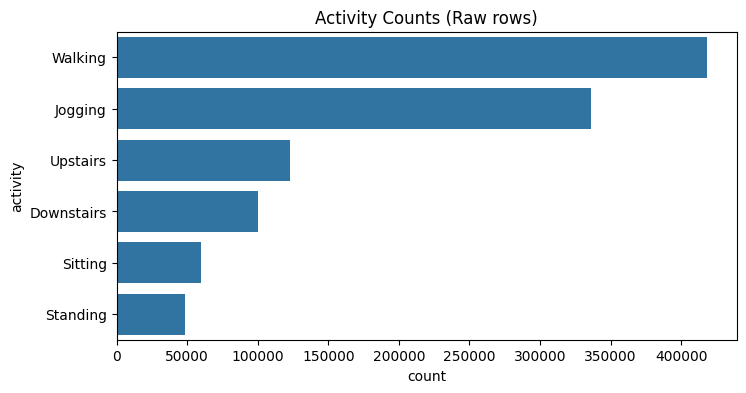

In [21]:
# EDA
# 활동별 샘플 개수
plt.figure(figsize=(8,4))
sns.countplot(y="activity", data=df, order=df["activity"].value_counts().index)
plt.title("Activity Counts (Raw rows)")
plt.show()

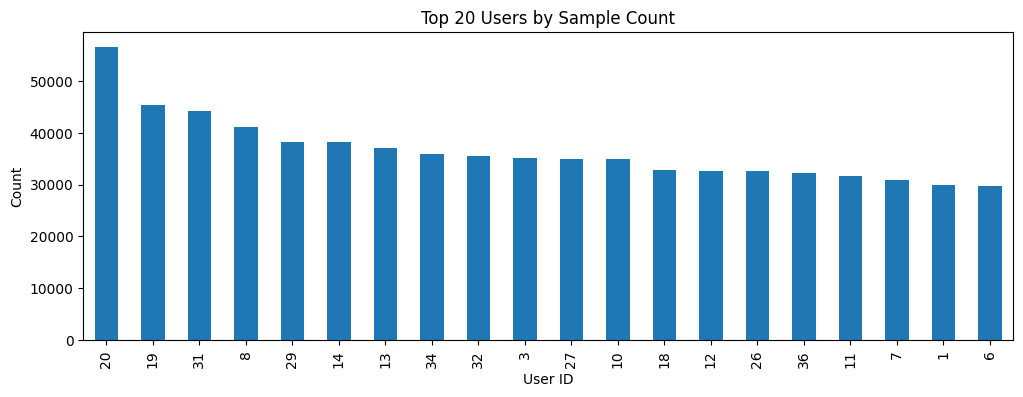

In [22]:
# 사용자별 샘플 분포 (상위 20명)
plt.figure(figsize=(12,4))
df["user"].value_counts().iloc[:20].plot(kind="bar")
plt.title("Top 20 Users by Sample Count")
plt.xlabel("User ID")
plt.ylabel("Count")
plt.show()

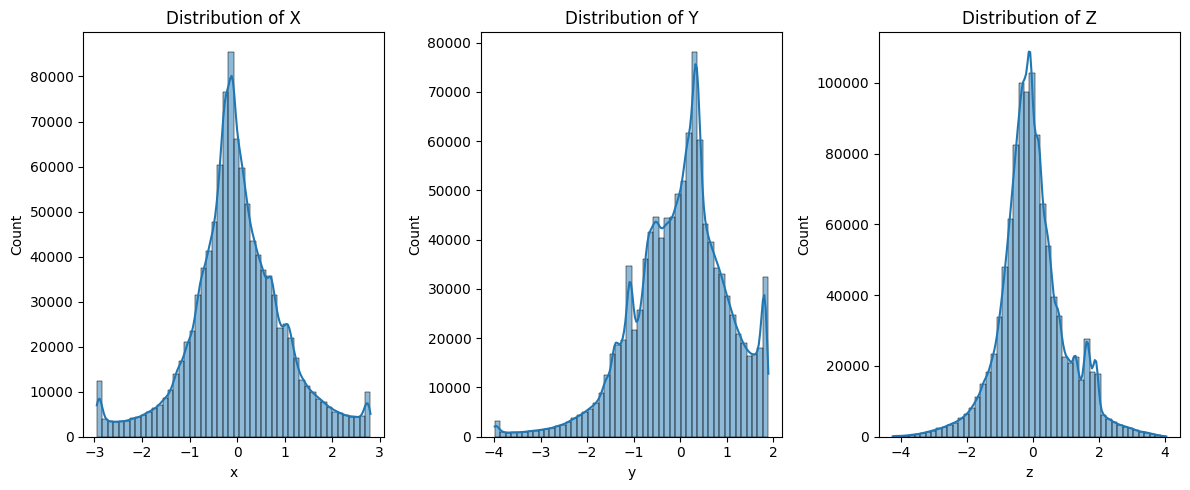

In [23]:
# 축별 통계 분포
plt.figure(figsize=(12,5))
for i, axis in enumerate(["x","y","z"]):
    plt.subplot(1,3,i+1)
    sns.histplot(df[axis], bins=50, kde=True)
    plt.title(f"Distribution of {axis.upper()}")
plt.tight_layout()
plt.show()

In [24]:
# 액티비티별 평균/표준편차 (EDA 테이블)
summary = df.groupby("activity")[["x","y","z"]].agg(["mean","std"])
print(summary)

                   x                   y                   z          
                mean       std      mean       std      mean       std
activity                                                              
Downstairs -0.027993  0.720733  0.200923  0.727732  0.060152  0.778555
Jogging    -0.128445  1.333301 -0.268839  1.367534 -0.115097  1.228136
Sitting     0.173372  0.692094 -0.800125  0.483361  1.294240  0.784605
Standing   -0.267930  0.470481  0.258344  0.187659  0.038317  0.289178
Upstairs   -0.041124  0.799164  0.128417  0.725648 -0.015575  0.749381
Walking     0.128236  0.847227  0.214989  0.745190 -0.107155  0.844031


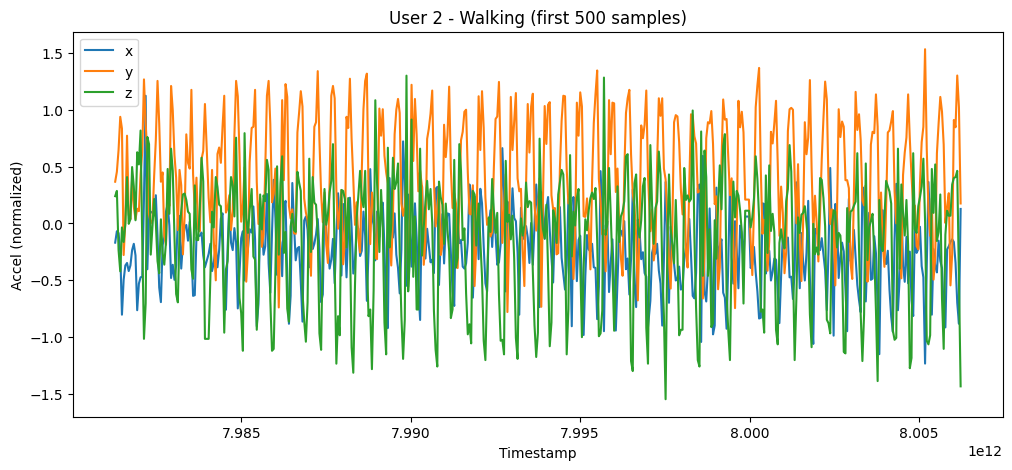

In [25]:
# 짧은 시계열 시각화 (랜덤 사용자 & 랜덤 액티비티 구간)
sample_user = np.random.choice(df["user"].unique())
sample_act  = np.random.choice(df["activity"].unique())
sub = df[(df["user"]==sample_user) & (df["activity"]==sample_act)].head(500)

plt.figure(figsize=(12,5))
plt.plot(sub["timestamp"], sub["x"], label="x")
plt.plot(sub["timestamp"], sub["y"], label="y")
plt.plot(sub["timestamp"], sub["z"], label="z")
plt.legend()
plt.title(f"User {sample_user} - {sample_act} (first 500 samples)")
plt.xlabel("Timestamp")
plt.ylabel("Accel (normalized)")
plt.show()

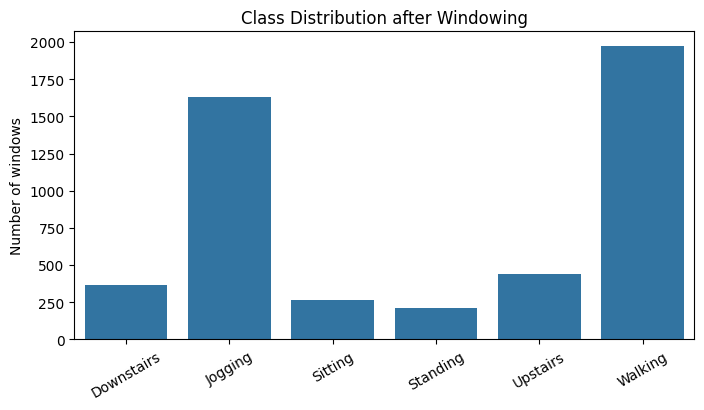

In [26]:
# 윈도우 생성 후 클래스 분포 (학습 입력 기준)
unique, counts = np.unique(y, return_counts=True)
plt.figure(figsize=(8,4))
sns.barplot(x=class_names, y=counts)
plt.title("Class Distribution after Windowing")
plt.ylabel("Number of windows")
plt.xticks(rotation=30)
plt.show()

In [27]:
# 7) 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=True, stratify=y, random_state=SEED
)
num_classes = len(np.unique(y))
input_shape = (X.shape[1], X.shape[2])
y_train_cat = utils.to_categorical(y_train, num_classes)
y_test_cat  = utils.to_categorical(y_test,  num_classes)

In [28]:
# 8) 1D-CNN
def build_cnn(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)

    x = layers.Conv1D(64, kernel_size=7, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling1D(2)(x)
    x = layers.Dropout(0.2)(x)

    x = layers.Conv1D(128, kernel_size=5, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling1D(2)(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Conv1D(256, kernel_size=3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.GlobalAveragePooling1D()(x)

    x = layers.Dropout(0.4)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    model = models.Model(inputs, outputs)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-3),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

model = build_cnn(input_shape, num_classes)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 200, 3)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 200, 64)        │         1,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 200, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_3 (ReLU)                  │ (None, 200, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 100, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 100, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 100, 128)       │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 100, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_4 (ReLU)                  │ (None, 100, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 50, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 50, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 50, 256)        │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 50, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_5 (ReLU)                  │ (None, 50, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_1      │ (None, 256)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 144,390 (564.02 KB)

 Trainable params: 143,494 (560.52 KB)

 Non-trainable params: 896 (3.50 KB)

## 1D-CNN 기반 시계열 분류 모델
- Conv 블록 3개: 짧은→중간→긴 패턴 점차 추출

- 풀링 + Dropout: 과적합 방지 및 계산 효율성 개선

- GlobalAveragePooling: 시퀀스를 벡터로 압축 → Dense로 분류

- Softmax 출력: 다중 클래스 확률 예측

In [29]:
# 9) 클래스 가중치
class_counts = np.bincount(y_train, minlength=num_classes)
total = class_counts.sum()
class_weight = {i: float(total / (num_classes * c)) for i, c in enumerate(class_counts)}
print("class_weight:", class_weight)

class_weight: {0: 2.2359679266895762, 1: 0.49974398361495137, 2: 3.113237639553429, 3: 3.8050682261208575, 4: 1.8432483474976393, 5: 0.41233629066328686}


In [30]:
# 10) 학습
es  = callbacks.EarlyStopping(patience=8, restore_best_weights=True, monitor="val_accuracy")
rlr = callbacks.ReduceLROnPlateau(factor=0.5, patience=4, verbose=1)

history = model.fit(
    X_train, y_train_cat,
    validation_split=0.2,
    epochs=50,
    batch_size=256,
    class_weight=class_weight,
    callbacks=[es, rlr],
    verbose=1
)

Epoch 1/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 11s 650ms/step - accuracy: 0.3976 - loss: 1.4748 - val_accuracy: 0.4200 - val_loss: 1.4351 - learning_rate: 0.0010
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 505ms/step - accuracy: 0.7210 - loss: 0.8330 - val_accuracy: 0.5160 - val_loss: 1.1731 - learning_rate: 0.0010
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 12s 597ms/step - accuracy: 0.7687 - loss: 0.6635 - val_accuracy: 0.6197 - val_loss: 1.0791 - learning_rate: 0.0010
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 11s 645ms/step - accuracy: 0.8455 - loss: 0.5386 - val_accuracy: 0.7157 - val_loss: 1.0499 - learning_rate: 0.0010
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 490ms/step - accuracy: 0.8777 - loss: 0.4535 - val_accuracy: 0.6837 - val_loss: 1.0859 - learning_rate: 0.0010
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 623ms/step - accuracy: 0.8951 - loss: 0.4010 - val_accuracy: 0.5365 - val_loss: 1.1976 - learning_rate: 0.0010
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 478ms/step - accuracy: 0.9138 - loss: 0.3473

In [31]:
# 11) 평가
test_loss, test_acc = model.evaluate(X_test, y_test_cat, verbose=0)
print(f"[TEST] loss={test_loss:.4f} acc={test_acc:.4f}")

y_pred = model.predict(X_test, verbose=0).argmax(axis=1)
print("\n=== Classification Report ===")
print(classification_report(y_test, y_pred, target_names=class_names))

[TEST] loss=1.0697 acc=0.7131

=== Classification Report ===
              precision    recall  f1-score   support

  Downstairs       0.39      0.67      0.49        73
     Jogging       0.99      0.91      0.95       325
     Sitting       0.55      0.89      0.68        53
    Standing       0.54      1.00      0.70        43
    Upstairs       0.30      0.60      0.40        88
     Walking       1.00      0.53      0.69       394

    accuracy                           0.71       976
   macro avg       0.63      0.77      0.65       976
weighted avg       0.84      0.71      0.74       976



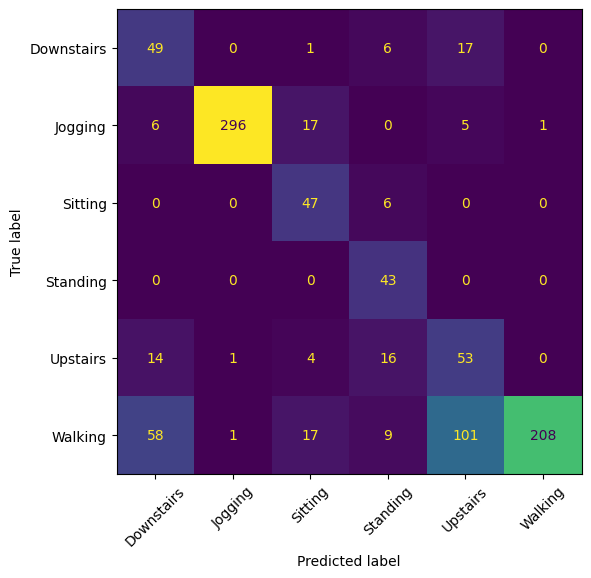

In [32]:
# 12) 혼동행렬
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(ax=ax, xticks_rotation=45, colorbar=False)
plt.tight_layout()
plt.show()

## 혼동행렬
- 분류 모델이 얼마나 잘 맞췄는지를 한눈에 보여주는 표

- 혼동행렬은 정확도(Accuracy) 말고도 다양한 지표 계산의 근거가 된다.
  - 정확도(Accuracy) = 전체 맞춘 수 / 전체 샘플
  - 정밀도(Precision) = 특정 클래스라고 예측한 것 중 실제로 맞은 비율
  - 재현율(Recall) = 실제 특정 클래스 중에서 맞게 예측한 비율
  - F1-score = Precision과 Recall의 조화평균